In [10]:
! pwd
! pip uninstall sympytorch -y

/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning


Found existing installation: sympytorch 0.1.4
Uninstalling sympytorch-0.1.4:
  Successfully uninstalled sympytorch-0.1.4


In [8]:
import os
import sys


ROOT="/home/guillermo.carrilho/PhysicsSimulationDeepLearning"
#ROOT="/share_zeta/Proxy-Sim/PhysicsSimulationDeepLearning"

sys.path.append(os.path.join(ROOT,"Physical_models"))
sys.path.append(os.path.join(ROOT,"DL_models"))

# stable fluids approach

Equation solve by this algorithm is:
$$\frac{\partial \textbf{u}}{\partial t} = -(\textbf{u} \cdot \nabla ) \textbf{u} - \frac{1}{\rho} \nabla p + \nu \nabla^2 \textbf{u} + \textbf{f}$$

### The case of this implementation is

$$\frac{\partial \textbf{u}}{\partial t} = -(\textbf{u} \cdot \nabla ) \textbf{u} - \frac{1}{\rho} \nabla p + \nu \nabla^2 \textbf{u}$$

In [9]:
#from Differentiable_simulation import dK_w,K_w,K_o,grad_phi_dK
from phi.torch.flow import *
from phi.torch.flow import diffuse, advect, Solve, fluid, math,Field, unstack,stack,batch,field,vec


class physical_model(object):
  # In the case of this solver, domain is not a field, it is a tuples of velocity field and pressure field
  def __init__(self,domain,dt):
    #self.v0=v0
    self.domain=domain
    self.dt=dt
    self.p=None

  def momentum_eq(self,u, u_prev, dt, diffusivity=0.01):
    diffusion_term = dt * diffuse.implicit(u,diffusivity, dt=dt,correct_skew=False)
    advection_term = dt * advect.semi_lagrangian(u, u_prev,dt)
    return u + advection_term + diffusion_term


  def implicit_time_step(self, v, dt):
      v=v[0]
      v = math.solve_linear(self.momentum_eq, v, Solve('CG-adaptive',
                                                    1e-2,
                                                    1e-2,x0=v), u_prev=v, dt=-dt)
      v,p = fluid.make_incompressible(v,solve=Solve('CG-adaptive',
                                                    1e-2,
                                                    1e-2,
                                                          #x0=self.p
                                                          ))
      return v,p

  def step(self,v):
    return self.implicit_time_step(v,self.dt)
  

class physical_model(object):
  def __init__(self,domain,dt,advection_solver,projection_solver):
    #self.v0=v0
    self.domain=domain
    self.dt=dt
    self.p=None
    self.advection_solver=advection_solver
    self.projection_solver=projection_solver

  def momentum_eq(self,u, u_prev, dt, diffusivity=0.01):
    diffusion_term = dt * diffuse.implicit(u,diffusivity, dt=dt,correct_skew=False)
    advection_term = dt * advect.semi_lagrangian(u, u_prev,dt)
    return u + advection_term + diffusion_term


  def implicit_time_step(self, v, dt):
      v = math.solve_linear(self.momentum_eq, v, self.advection_solver(v), u_prev=v, dt=-dt)
      v,p = fluid.make_incompressible(v,solve=self.projection_solver)
      return v

  def step(self,v):
      return self.implicit_time_step(v,self.dt)
  

geo=UniformGrid(x=60, y=60,bounds=Box(x=1.0, y=1.0))
phi_w=Field( geo,values=vec(x=0.0,y=0.0),
      boundary= {
          'x-': vec(x=0.1,y=0.0),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0
 })

phy=physical_model(
   phi_w,0.01,
   advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
   projection_solver=Solve('CG-adaptive',1e-3,1e-3)
)

# Multi resolution adaptation

### 2D

In [152]:
from random import choice
from einops import rearrange
from Differentiable_simulation import Space2Tensor,Tensor2Space
from phi.torch.flow import *
import torch
import time

def Tensor2Space(Tensor,geometry,tensor_signature='c x y->x y c',space_signature="x:s,y:s,vector:c"):
  #return math.wrap(rearrange(Tensor[0],'c x y->x y c'),"x:s,y:s,vector:c")
  return Field(geometry=geometry,values=math.wrap(rearrange(Tensor[0],'c x y->x y c'),"x:s,y:s,vector:c"))

class SOL_trainer(object):
    def __init__(self,boundary,model,optimizer,simulation_steps,spatial_step,time_step,coarse_to_fine_timefactor=1/4,co2gt_spatial_factor=4):
      self.boundary = boundary
      self.co2gt_spatial_factor=co2gt_spatial_factor
      self.spatial_step=spatial_step
      self.co2gt_time_factor=coarse_to_fine_timefactor
      self.co_dt=time_step
      self.gt_dt=self.co_dt*self.co2gt_time_factor

      self.geo_co=UniformGrid(x=self.spatial_step, y=self.spatial_step,
      #bounds=Box(x=10.0,y=10.0)
      )
      self.geo_gt=UniformGrid(x=self.spatial_step*self.co2gt_spatial_factor, y=self.spatial_step*self.co2gt_spatial_factor,
      #bounds=Box(x=10.0,y=10.0)
      )
      self.v_co=Field(self.geo_co,values=vec(x=tensor(0.0),y=tensor(0.0)),boundary=self.boundary) # add initial conditions
      self.v_gt=Field(self.geo_gt,values=vec(x=tensor(0.0),y=tensor(0.0)),boundary=self.boundary) # add initial conditions

      self.ph_model_co=physical_model(self.v_co,dt=self.co_dt,
                                      advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
                                      projection_solver=Solve('CG-adaptive',1e-3,1e-3))
      self.ph_model_gt=physical_model(self.v_gt,dt=self.gt_dt,
                                      advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
                                      projection_solver=Solve('CG-adaptive',1e-3,1e-3)
                                      )

      self.init_states_gt=[self.v_gt]
      for i in range(50):
        self.init_states_gt.append(self.ph_model_gt.step(self.init_states_gt[-1]))

      self.n_steps=simulation_steps
      self.st_model=model

      self.loss=(lambda y_,y: torch.sum((y-y_)**2)/self.n_steps)

      self.optimizer=optimizer

      self.alpha=1

    def forward_prediction_correction(self):
      #print(f"prediction correction simulation")

      states_pred=[self.v_co]
      states_corr=[Tensor2Space(1e-3*torch.nn.functional.tanh(self.st_model(Space2Tensor(self.v_co,self.geo_co))),self.geo_co)]

      states_pred=[self.v_co+states_corr[-1]]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in range(self.n_steps):

        # Step last in states_pred
        start=time.time()
        states_pred.append(self.ph_model_co.step(states_pred[-1]))
        # Correct with model of last states_pred
        states_corr.append(Tensor2Space(1e-3*torch.nn.functional.tanh(self.st_model(Space2Tensor(states_pred[-1],self.geo_co))),self.geo_co))
        end=time.time()
        # Sum correction to last in states pred
        states_pred[-1]=states_pred[-1]+states_corr[-1]
        print(end-start)

      states_pred=list(map(lambda corr:Space2Tensor(corr,self.geo_gt),states_pred))

      return states_pred,states_corr

    def forward_fine_grained(self):
      states_gt=[Space2Tensor(self.v_gt,self.geo_gt)]

      #print(f"fine grained simulation")
      for i in range(int(self.n_steps/self.co2gt_time_factor)):
        ##print(f"fine grained step {i}")
        self.v_gt=self.ph_model_gt.step(self.v_gt)
        if i%int(1/self.co2gt_time_factor)==0:
          states_gt.append(Space2Tensor(self.v_gt,self.geo_gt))
      return states_gt

    def train(self,epochs):
      losses=[]
      for i in range(epochs):
        #print(f"epoch {i}")
        gt_batch=[]
        co_batch=[]
        for b in range(10):
          print(f"making batch {b}")
          self.v_gt=choice(self.init_states_gt)
          states_gt=self.forward_fine_grained()
          self.v_co=Field(values=Tensor2Space(states_gt[0].detach(),self.geo_co),geometry=self.geo_co,boundary=self.boundary)
          print(f"last roll initial state")
          #plot(Field(values=Tensor2Space(states_gt[0],self.geo_co),geometry=self.geo_co,boundary=self.boundary))
          #plot(self.v_co)
          #plt.show()
          states_pred,states_corr=self.forward_prediction_correction()
          gt_batch=gt_batch+states_gt
          co_batch=co_batch+states_pred

        print("training batch")
        states_pred=torch.concat(states_pred,axis=0)
        states_gt=torch.concat(states_gt,axis=0)
        loss=self.loss(states_pred,states_gt)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        losses.append(loss.cpu().detach().numpy())
      return losses

      def test(self,epochs):
        losses=[]
        for i in range(epochs):
          #self.alpha=self.alpha*(i/epochs)
          states_pred,states_corr=self.forward_prediction_correction()
          states_gt=self.forward_fine_grained()

          states_pred=torch.concat(states_pred,axis=0)
          states_gt=torch.concat(states_gt,axis=0)
          loss=self.loss(states_pred,states_gt)

          losses.append(loss.cpu().detach().numpy())
        return losses


In [153]:
from DL_models.Models.CNN_models import simple_cnn_model

boundary = {'x-': vec(x=0.5,y=0.0),
            'x+': ZERO_GRADIENT,
            'y-':0,
            'y+':0
            }

model=simple_cnn_model().train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
T=SOL_trainer(boundary,model,optimizer,
              simulation_steps=3,spatial_step=64,time_step=0.01,coarse_to_fine_timefactor=1/2,co2gt_spatial_factor=1)

/usr/local/lib/python3.10/dist-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


In [154]:
ll=[]

making batch 0
last roll initial state
0.2938101291656494
0.29390740394592285
0.297168493270874
making batch 1
last roll initial state
0.2918517589569092
0.2923285961151123
0.2907118797302246
making batch 2
last roll initial state
0.305645227432251
0.29856204986572266
0.293428897857666
making batch 3
last roll initial state
0.2938876152038574
0.292954683303833
0.29554104804992676
making batch 4
last roll initial state
0.29635024070739746
0.29729604721069336
0.2968015670776367
making batch 5
last roll initial state
0.2968130111694336
0.6159625053405762
0.3163774013519287
making batch 6
last roll initial state
0.29637598991394043
0.29803943634033203
0.2951931953430176
making batch 7
last roll initial state
0.29619312286376953
0.29437804222106934
0.2937135696411133
making batch 8
last roll initial state
0.2958564758300781
0.29692840576171875
0.29476165771484375
making batch 9
last roll initial state
0.29643678665161133
0.2954273223876953
0.29375743865966797
training batch


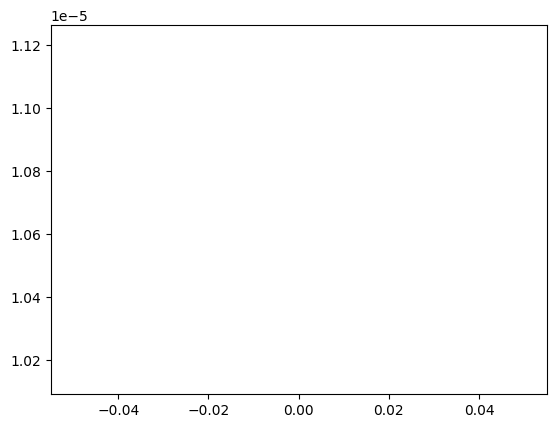

making batch 0
last roll initial state
0.2913784980773926
0.29120659828186035
0.29163217544555664
making batch 1
last roll initial state
0.29323339462280273
0.29374146461486816
0.29389476776123047
making batch 2
last roll initial state
0.294466495513916
0.2943994998931885
0.40487170219421387
making batch 3
last roll initial state
0.2955000400543213
0.2938082218170166
0.2951226234436035
making batch 4
last roll initial state
0.29596519470214844
0.29535531997680664
0.29494524002075195
making batch 5
last roll initial state
0.29480600357055664
0.29388856887817383
0.2942626476287842
making batch 6
last roll initial state
0.30121517181396484
0.2957732677459717
0.29561829566955566
making batch 7
last roll initial state
0.29308152198791504
0.29396653175354004
0.2966184616088867
making batch 8
last roll initial state
0.29327917098999023
0.29466700553894043
0.29427099227905273
making batch 9
last roll initial state
0.29393649101257324
0.2943713665008545
0.29401087760925293
training batch


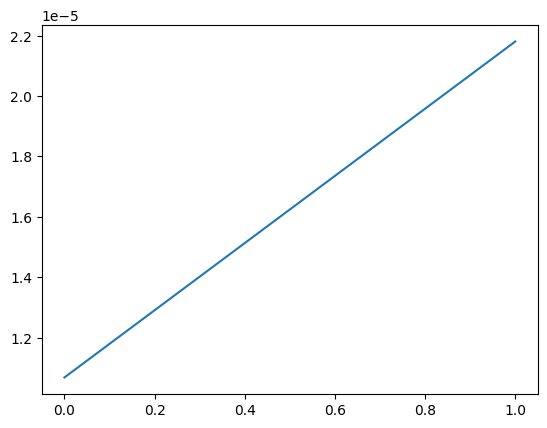

making batch 0
last roll initial state
0.29117321968078613
0.2910308837890625
0.2913787364959717
making batch 1
last roll initial state
0.2945370674133301
0.29452085494995117
0.29457521438598633
making batch 2
last roll initial state
0.2944362163543701
0.2950468063354492
0.29393768310546875
making batch 3
last roll initial state
0.2935178279876709
0.3874361515045166
0.30217504501342773
making batch 4
last roll initial state
0.29326963424682617
0.2929813861846924
0.29280877113342285
making batch 5
last roll initial state
0.29437899589538574
0.2937800884246826
0.2934608459472656
making batch 6
last roll initial state
0.29396796226501465
0.2933964729309082
0.2936091423034668
making batch 7
last roll initial state
0.31519627571105957
0.3145904541015625
0.31424784660339355
making batch 8
last roll initial state
0.2482290267944336
0.2950012683868408
0.29285597801208496
making batch 9
last roll initial state
0.29291677474975586
0.29320788383483887
0.2924790382385254
training batch


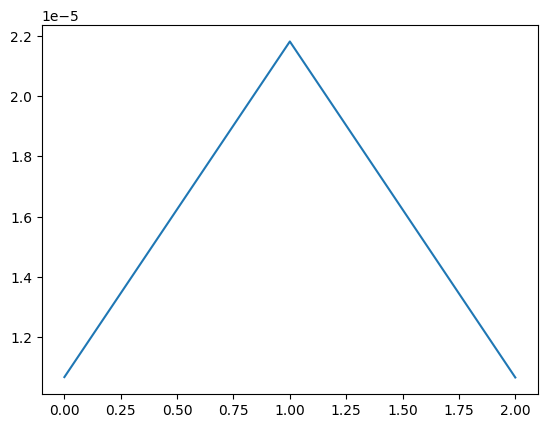

making batch 0
last roll initial state
0.2918527126312256
0.7801284790039062
0.31139612197875977
making batch 1
last roll initial state
0.29102277755737305
0.2927844524383545
0.29337000846862793
making batch 2
last roll initial state
0.29225945472717285
0.2923126220703125
0.29226112365722656
making batch 3
last roll initial state
0.2915916442871094
0.2919621467590332
0.293104887008667
making batch 4
last roll initial state
0.30449724197387695
0.2948741912841797
0.2944619655609131
making batch 5
last roll initial state
0.29328203201293945
0.2933313846588135
0.29242682456970215
making batch 6
last roll initial state
0.2930409908294678
0.29308223724365234
0.29453587532043457
making batch 7
last roll initial state
0.29358887672424316
0.2934074401855469
0.29290771484375
making batch 8
last roll initial state
0.29369664192199707
0.31975317001342773
0.2977745532989502
making batch 9
last roll initial state
0.29434895515441895
0.2938382625579834
0.29418253898620605
training batch


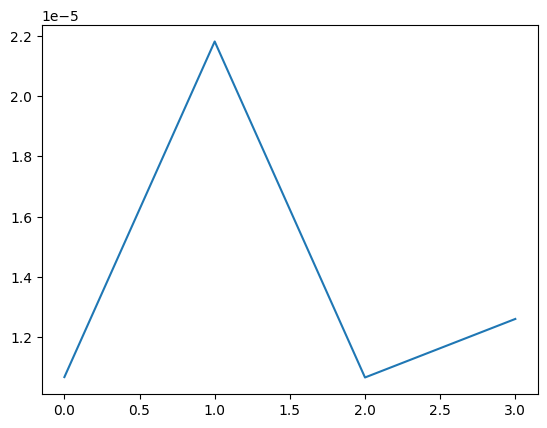

making batch 0
last roll initial state
0.29073095321655273
0.29028844833374023
0.29140710830688477
making batch 1
last roll initial state
0.3022892475128174
0.29535722732543945
0.2968907356262207
making batch 2
last roll initial state
0.2963395118713379
0.2958872318267822
0.2954099178314209
making batch 3
last roll initial state
0.29437994956970215
0.2937893867492676
0.2956061363220215
making batch 4
last roll initial state
0.2954437732696533
0.2949495315551758
0.29474306106567383
making batch 5
last roll initial state
0.29280972480773926
0.29207754135131836
0.2924213409423828
making batch 6
last roll initial state
0.29239583015441895
0.291384220123291
0.2915644645690918
making batch 7
last roll initial state
0.291440486907959
0.29146552085876465
0.2902069091796875
making batch 8
last roll initial state
0.292863130569458
0.29233789443969727
0.29192328453063965
making batch 9
last roll initial state
0.2927861213684082
0.2918376922607422
0.3031165599822998
training batch


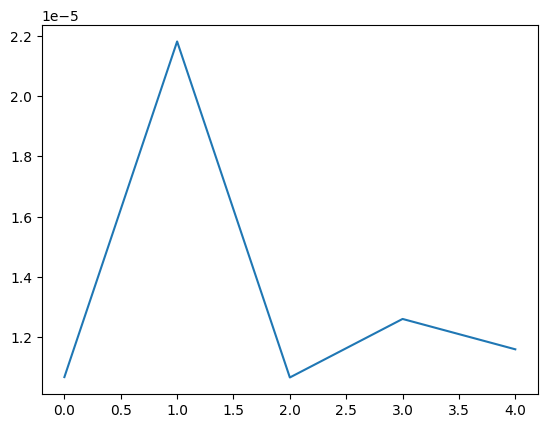

making batch 0
last roll initial state
0.2921261787414551
0.29244232177734375
0.29360198974609375
making batch 1
last roll initial state
0.2934134006500244
0.29273486137390137
0.2930257320404053
making batch 2
last roll initial state
0.2977757453918457
0.29891037940979004
0.29396510124206543
making batch 3
last roll initial state
0.2932446002960205
0.29383134841918945
0.2936410903930664
making batch 4


KeyboardInterrupt: 

In [155]:
import matplotlib.pyplot as plt
for i in range(50):
  l=T.train(1)
  ll=ll+l
  plt.plot(ll)
  plt.show()

7.1642007e-06

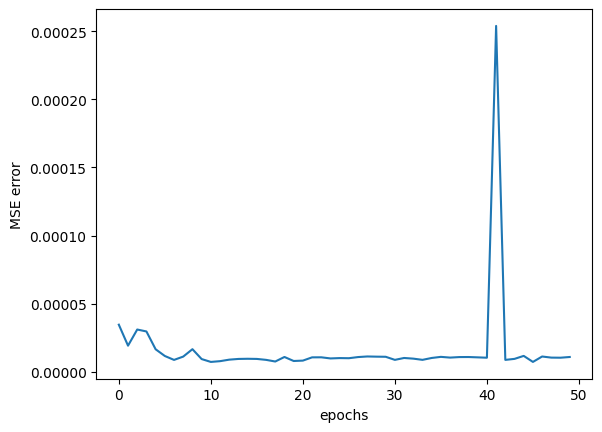

In [151]:
import numpy as np
plt.plot(ll)
plt.xlabel("epochs")
plt.ylabel("MSE error")
np.array(ll).min()
# 0.29 sec

### 3D

In [167]:
geo=UniformGrid(x=60, y=60,z=60,
                #bounds=Box(x=1.0, y=1.0, z=1.0)
                )
phi_w=Field( geo,values=vec(x=0.0,y=0.0,z=0.0),
      boundary= {
          'x-': vec(x=tensor(0.1),y=tensor(0.0),z=tensor(0.0)),
          'x+': ZERO_GRADIENT,
          'y-': 0,
          'y+': 0,
          'z-': 0,
          'z+': 0
 })

phy=physical_model(
   phi_w,0.01,
   advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
   projection_solver=Solve('CG-adaptive',1e-3,1e-3)
)

phy=physical_model(phi_w,0.01,
                                      advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
                                      projection_solver=Solve('CG-adaptive',1e-3,1e-3))

In [168]:
phy.step(phi_w)

AttributeError: 'torch.dtype' object has no attribute 'char'

In [259]:
from random import choice
from einops import rearrange
from Differentiable_simulation import Space2Tensor,Tensor2Space
from phi.torch.flow import *
import torch
import time

def Tensor2Space(Tensor,geometry,tensor_signature='c x y z->x y z c',space_signature="x,y,z,vector:c"):
  #return math.wrap(rearrange(Tensor[0],'c x y->x y c'),"x,y,z,vector")
  return Field(geometry=geometry,values=math.wrap(rearrange(Tensor[0],tensor_signature),space_signature))

def Space2Tensor(Space,geometry,space_signature="x,y,z,vector",tensor_signature="b x y z c->b c x y z"):
  return rearrange(Space.sample(geometry).native(space_signature).unsqueeze(0),tensor_signature)
  
#def Space2Tensor(Space,geometry,space_signature='x,y,vector,',tensor_signature="b x y c->b c x y"):
#  return rearrange(Space.sample(geometry).native(space_signature).unsqueeze(0),tensor_signature)




class SOL_trainer(object):
    def __init__(self,boundary,model,optimizer,simulation_steps,spatial_step,time_step,coarse_to_fine_timefactor=1/4,co2gt_spatial_factor=4):
      self.boundary = boundary
      self.co2gt_spatial_factor=co2gt_spatial_factor
      self.spatial_step=spatial_step
      self.co2gt_time_factor=coarse_to_fine_timefactor
      self.co_dt=time_step
      self.gt_dt=self.co_dt*self.co2gt_time_factor

      self.geo_co=UniformGrid(x=self.spatial_step, y=self.spatial_step, z=self.spatial_step,
      #bounds=Box(x=10.0,y=10.0)
      )
      self.geo_gt=UniformGrid(x=self.spatial_step*self.co2gt_spatial_factor, y=self.spatial_step*self.co2gt_spatial_factor,z=self.spatial_step*self.co2gt_spatial_factor,
      #bounds=Box(x=10.0,y=10.0)
      )
      self.v_co=Field(self.geo_co,values=vec(x=tensor(0.0),y=tensor(0.0),z=tensor(0.0)),boundary=self.boundary) # add initial conditions
      self.v_gt=Field(self.geo_gt,values=vec(x=tensor(0.0),y=tensor(0.0),z=tensor(0.0)),boundary=self.boundary) # add initial conditions

      self.ph_model_co=physical_model(self.v_co,dt=self.co_dt,
                                      advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
                                      projection_solver=Solve('CG-adaptive',1e-3,1e-3))
      self.ph_model_gt=physical_model(self.v_gt,dt=self.gt_dt,
                                      advection_solver=(lambda v: Solve('CG-adaptive',1e-3,1e-3,x0=v)),
                                      projection_solver=Solve('CG-adaptive',1e-3,1e-3)
                                      )

      self.init_states_gt=[self.v_gt]
      for i in range(3):
        self.init_states_gt.append(self.ph_model_gt.step(self.init_states_gt[-1]))

      self.n_steps=simulation_steps
      self.st_model=model

      self.loss=(lambda y_,y: torch.sum((y-y_)**2)/self.n_steps)

      self.optimizer=optimizer

      self.alpha=1

    def forward_prediction_correction(self):
      #print(f"prediction correction simulation")

      states_pred=[self.v_co]
      states_corr=[Tensor2Space(1e-3*torch.nn.functional.tanh(self.st_model(Space2Tensor(self.v_co,self.geo_co))),self.geo_co)]

      states_pred=[self.v_co+states_corr[-1]]

      # For steps in correction run (4 in example) (incidencia nos iniciais)
      for i in range(self.n_steps):

        # Step last in states_pred
        start=time.time()
        states_pred.append(self.ph_model_co.step(states_pred[-1]))
        # Correct with model of last states_pred
        states_corr.append(Tensor2Space(1e-3*torch.nn.functional.tanh(self.st_model(Space2Tensor(states_pred[-1],self.geo_co))),self.geo_co))
        end=time.time()
        # Sum correction to last in states pred
        states_pred[-1]=states_pred[-1]+states_corr[-1]
        print(end-start)

      states_pred=list(map(lambda corr:Space2Tensor(corr,self.geo_gt),states_pred))

      return states_pred,states_corr

    def forward_fine_grained(self):
      states_gt=[Space2Tensor(self.v_gt,self.geo_gt)]

      #print(f"fine grained simulation")
      for i in range(int(self.n_steps/self.co2gt_time_factor)):
        ##print(f"fine grained step {i}")
        self.v_gt=self.ph_model_gt.step(self.v_gt)
        if i%int(1/self.co2gt_time_factor)==0:
          states_gt.append(Space2Tensor(self.v_gt,self.geo_gt))
      return states_gt

    def train(self,epochs):
      losses=[]
      for i in range(epochs):
        #print(f"epoch {i}")
        gt_batch=[]
        co_batch=[]
        for b in range(5):
          print(f"making batch {b}")
          self.v_gt=choice(self.init_states_gt)
          states_gt=self.forward_fine_grained()
          self.v_co=Field(values=Tensor2Space(states_gt[0].detach(),self.geo_co),geometry=self.geo_co,boundary=self.boundary)
          print(f"last roll initial state")
          #plot(Field(values=Tensor2Space(states_gt[0],self.geo_co),geometry=self.geo_co,boundary=self.boundary))
          #plot(self.v_co)
          #plt.show()
          states_pred,states_corr=self.forward_prediction_correction()
          gt_batch=gt_batch+states_gt
          co_batch=co_batch+states_pred

        print("training batch")
        states_pred=torch.concat(states_pred,axis=0)
        states_gt=torch.concat(states_gt,axis=0)
        loss=self.loss(states_pred,states_gt)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        losses.append(loss.cpu().detach().numpy())
      return losses

      def test(self,epochs):
        losses=[]
        for i in range(epochs):
          #self.alpha=self.alpha*(i/epochs)
          states_pred,states_corr=self.forward_prediction_correction()
          states_gt=self.forward_fine_grained()

          states_pred=torch.concat(states_pred,axis=0)
          states_gt=torch.concat(states_gt,axis=0)
          loss=self.loss(states_pred,states_gt)

          losses.append(loss.cpu().detach().numpy())
        return losses


In [260]:
import torch
from einops import rearrange
import matplotlib.pyplot as plt

class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv3d(3, 32, 9, padding=4)
    self.conv2=torch.nn.Conv3d(32, 64, 9, padding=4)
    self.conv3=torch.nn.Conv3d(64, 3, 9, padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x

In [261]:
#from DL_models.Models.CNN_models import simple_cnn_model

boundary = {'x-': vec(x=0.5,y=0.0,z=0.0),
            'x+': ZERO_GRADIENT,
            'y-':0,
            'y+':0,
            'z-':0,
            'z+':0
            }

model=simple_cnn_model().train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)
T=SOL_trainer(boundary,model,optimizer,
              simulation_steps=3,spatial_step=64,time_step=0.01,coarse_to_fine_timefactor=1/2,co2gt_spatial_factor=1)

In [262]:
ll=[]

making batch 0
last roll initial state
4.83887505531311
5.970017433166504
6.092892646789551
making batch 1
last roll initial state
6.13907265663147
6.417086839675903
6.031594753265381
making batch 2
last roll initial state
5.971026659011841
6.023333549499512
5.862896680831909
making batch 3
last roll initial state
6.054138660430908
6.101717472076416
6.034753084182739
making batch 4
last roll initial state
6.295249938964844
6.047783136367798
5.948972225189209
training batch


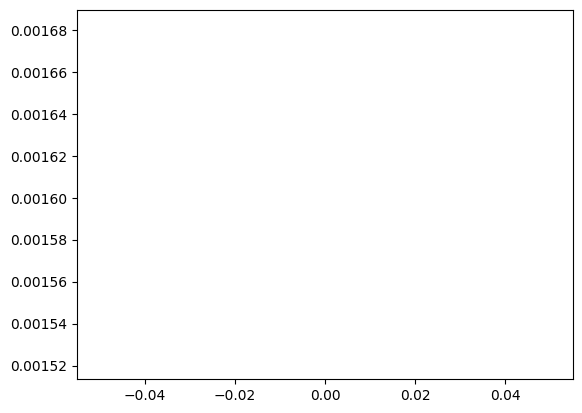

making batch 0
last roll initial state
4.666757345199585
6.639121770858765
6.246592044830322
making batch 1
last roll initial state
6.06947660446167
6.049327611923218
6.267709732055664
making batch 2
last roll initial state
6.020373582839966
5.971491813659668
6.0191404819488525
making batch 3
last roll initial state
5.99509859085083
6.35871958732605
6.041213512420654
making batch 4
last roll initial state
5.968512773513794
6.165012836456299
6.381924629211426
training batch


NotConverged: Φ-ML CG (PyTorch*) did not converge to rel_tol=1e-03, abs_tol=1e-03 within 1000 iterations. Max residual: 0.0010969645

In [263]:
import matplotlib.pyplot as plt
for i in range(50):
  l=T.train(1)
  ll=ll+l
  plt.plot(ll)
  plt.show()

# PINNS BASED

## 2D

In [3]:
class simple_cnn_model(torch.nn.Module):
  def __init__(self):
    super(simple_cnn_model,self).__init__()

    self.conv1=torch.nn.Conv2d(2, 32, (9,9), padding=4)
    self.conv2=torch.nn.Conv2d(32, 64, (9,9), padding=4)
    self.conv3=torch.nn.Conv2d(64, 2, (9,9), padding=4)
    self.act1=torch.nn.ReLU()
    self.act2=torch.nn.ReLU()
    self.act3=torch.nn.Tanh()
  def forward(self,x):
    x=self.act1(self.conv1(x))
    x=self.act2(self.conv2(x))
    x=self.act3(self.conv3(x))*1
    #x=torch.clamp(x, min=-0.5, max=0.5)
    return x[0]

In [12]:
boundary = {'x-': vec(x=1.0,y=0.0),
            'x+': ZERO_GRADIENT,
            'y-':0,
            'y+':0
            }
boundary
geo=UniformGrid(x=128, y=128,bounds=Box(x=100, y=100))
v0=Field(geo,values=vec(x=tensor(0.0),y=tensor(0.0)),boundary=boundary)

phys=physical_model(v0,dt=0.1,
                    #advection_solver=(lambda v: Solve('CG-adaptive',1e-2,1e-2,x0=v)),projection_solver=Solve('CG-adaptive',1e-2,1e-2)
                    )

#from DL_models.Models.CNN_models import simple_cnn_model

model=simple_cnn_model().train()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

In [17]:
v,p = fluid.make_incompressible(v0,solve=Solve('CG-adaptive',1e-2,1e-2))

/usr/local/lib/python3.10/dist-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


In [13]:
phys.step(v0)



Field[(xˢ=128, yˢ=128, vectorᶜ=x,y)]

In [14]:
from Train_differentiable_physics import PINNS_based_SOL_trainer
import torch
T=PINNS_based_SOL_trainer(
    field=(v0,fluid.make_incompressible(v0,solve=Solve('CG-adaptive',1e-2,1e-2))[-1]),
    model=model,
    optimizer=optimizer,
    simulation_steps=2,
    time_step=0.1,
    loss=torch.mean
    )

In [16]:
from random import randint
randint()

TypeError: Random.randint() missing 2 required positional arguments: 'a' and 'b'

In [15]:
T.train(5)

[array(0.5626921, dtype=float32),
 array(-0.45075464, dtype=float32),
 array(-0.6038111, dtype=float32),
 array(-0.64447063, dtype=float32),
 array(-0.6510437, dtype=float32)]

## 3D

/usr/local/lib/python3.10/dist-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


Diverged: Solve diverged within 819 iterations using Φ-ML CG (PyTorch*)

In [124]:
boundary = {'x-': vec(x=1.0,y=0.0,z=0.0),
            'x+': ZERO_GRADIENT,
            'y-':0,
            'y+':0,
            'z-':0,
            'z+':0
            }
boundary
geo=UniformGrid(x=128, y=128,z=128,bounds=Box(x=50, y=50,z=50))
v0=Field(geo,values=vec(x=tensor(0.0),y=tensor(0.0),z=tensor(0.0)),boundary=boundary)

phys=physical_model(v0,dt=0.1,
                    #advection_solver=(lambda v: Solve('CG-adaptive',1e-2,1e-2,x0=v)),projection_solver=Solve('CG-adaptive',1e-2,1e-2)
                    )

In [125]:
phys.step(v0)

/usr/local/lib/python3.10/dist-packages/phiml/math/_optimize.py:640: UserWarning: Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).
  warnings.warn("Possible rank deficiency detected. Matrix might be singular which can lead to convergence problems. Please specify using Solve(rank_deficiency=...).")


Field[(xˢ=128, yˢ=128, zˢ=128, vectorᶜ=x,y,z)]

In [130]:
v0.geometry

(xˢ=128, yˢ=128), bounds=Box(x=(0, 50), y=(0, 50))